# Tracks

In [1]:
"""
    TITLE   : Kalman-type Filter
    PROJECT : streamtrack
""";

__author__ = 'Nathaniel Starkman'

<span style='font-size:30px;font-weight:650'>
    About
</span>


Description of the model:

- The stream propagate along a smooth path with arclength $\ell$
- At index i = 0, the stream is at $\ell=0$, at some position $\vec{x}_0$
- The stream's stars are observed at discrete points along the arclength
- The stream's stars are distributed a distance from the stream given by the distribution $\mathcal{D}(\ell)$

    For this we take $\mathcal{D} = \mathcal{N}(\mu)$

The problem: estimate $\ell$ given observations of the stars.

<br><br>

- - - 


## Prepare

### Imports

In [2]:
from utilipy import ipython

ipython.set_autoreload(2)
ipython.run_imports(base=True, astropy=True, matplotlib=True)


# BUILT-IN

# import sys; sys.path.insert(0, "../")  # noqa
# import sys; sys.path.insert(1, "../streamtrack/")


# THIRD PARTY

import seaborn

# PROJECT-SPECIFIC

from streamtrack import examples
from streamtrack import preprocessing as prep



set autoreload to 1
set autoreload to 2


In [3]:
rng = np.random.default_rng()

### Orbit Data

In [4]:
osc = examples.make_ordered_orbit_data()
data = examples.make_noisy_orbit_data()

clrO = np.linspace(0, 256, len(data))

### Preprocess

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/nathanielstarkman/miniconda3/envs/dev/lib/python3.8/site-packages/minisom.py:365: UserWarning: PCA initialization inappropriate:One of the dimensions of the map is 1.
  warn(msg)



100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


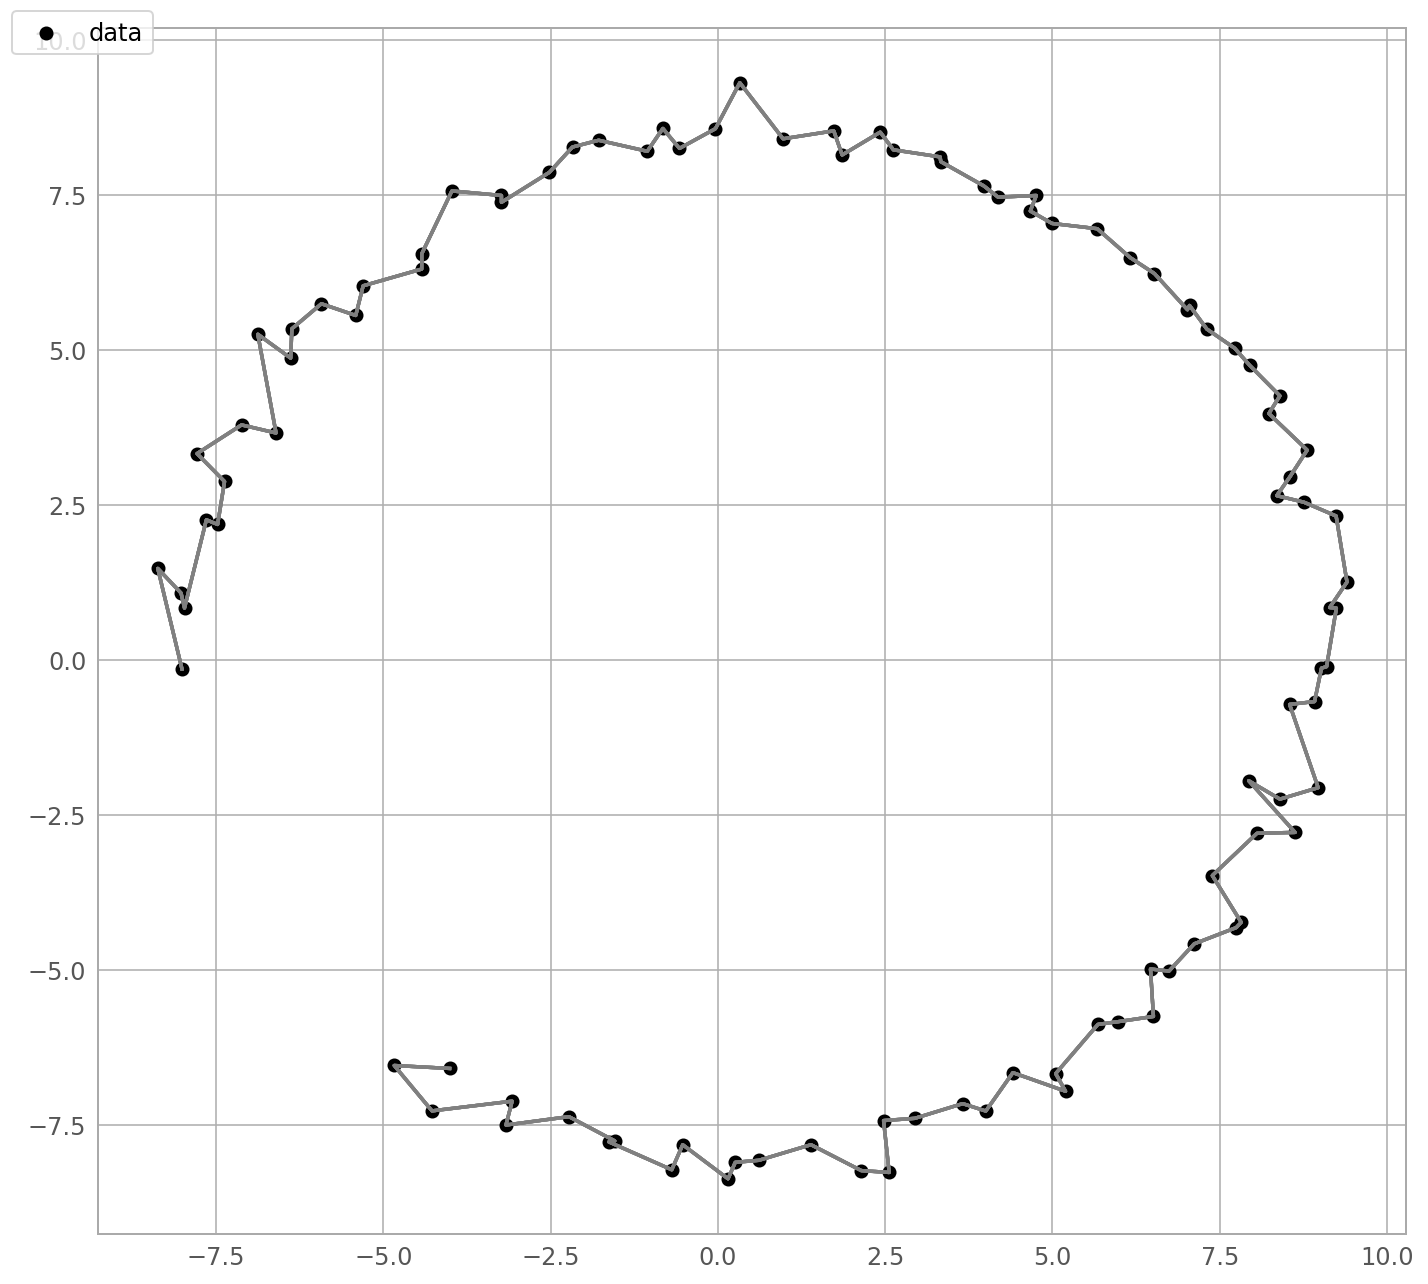

In [5]:
repdata, trmat, visit_orders = prep.preprocess(
    data,
    np.array((-5.1, -2, 0.)).reshape(1, -1),
    iterations=int(3e3),
    learning_rate=1.5,
    sigma=15,
    plot=True,
    random_seeds=np.arange(10, 20, 1),
    _tqdm=True,
)

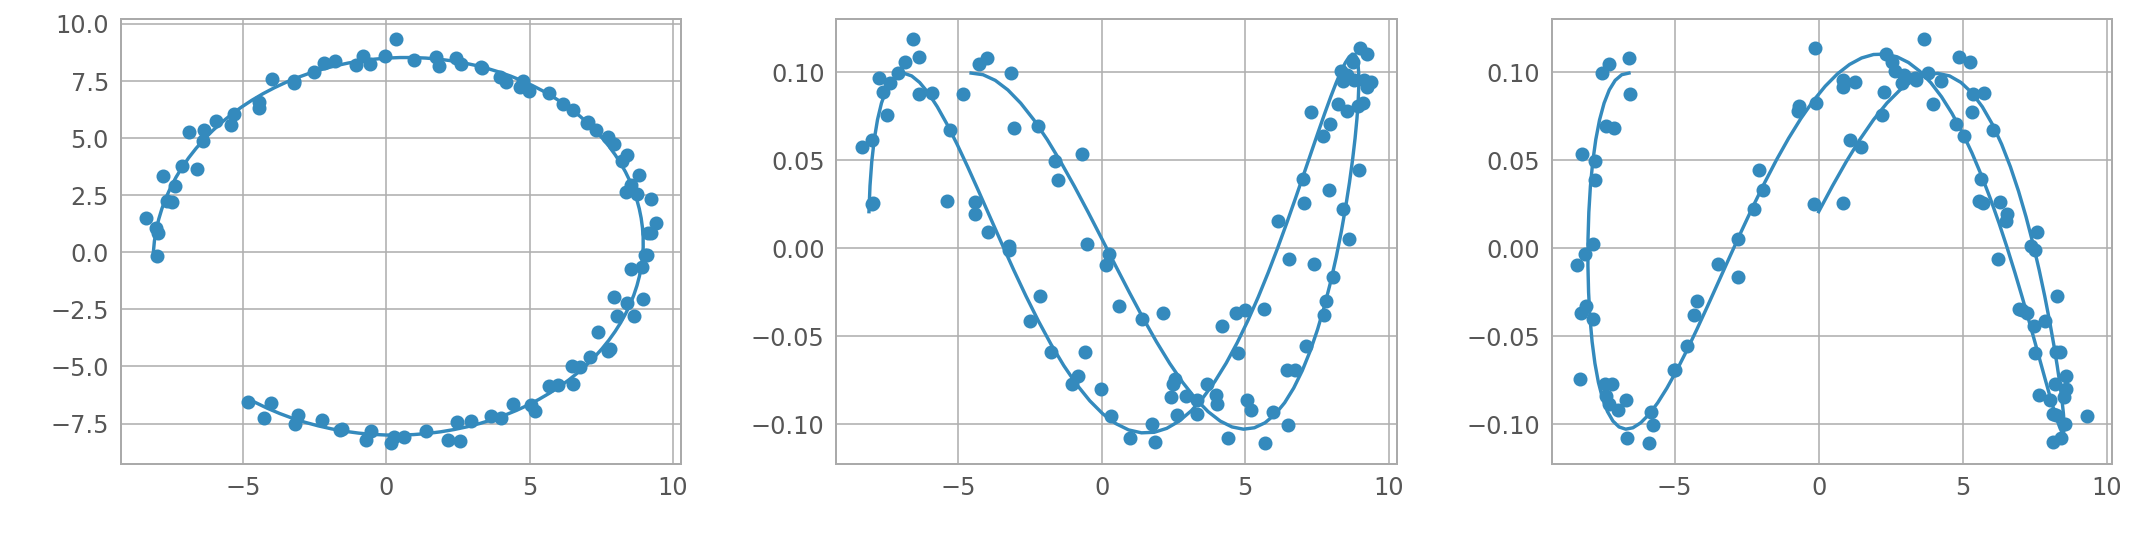

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(osc.x.value, osc.y.value)
axs[0].scatter(repdata.x, repdata.y)

axs[1].plot(osc.x.value, osc.z.value)
axs[1].scatter(repdata.x, repdata.z)

axs[2].plot(osc.y.value, osc.z.value)
axs[2].scatter(repdata.y, repdata.z)

plt.tight_layout()
plt.show();

<br><br>

- - - 


## Code

In [7]:
best_order = prep.draw_most_probable_ordering(trmat)

(array([ 8., 16., 23., 16., 18.,  8.,  5.,  1.,  2.,  2.]),
 array([0.07642892, 0.2349898 , 0.39355068, 0.55211156, 0.71067244,
        0.86923332, 1.0277942 , 1.18635508, 1.34491597, 1.50347685,
        1.66203773]),
 <a list of 10 Patch objects>)

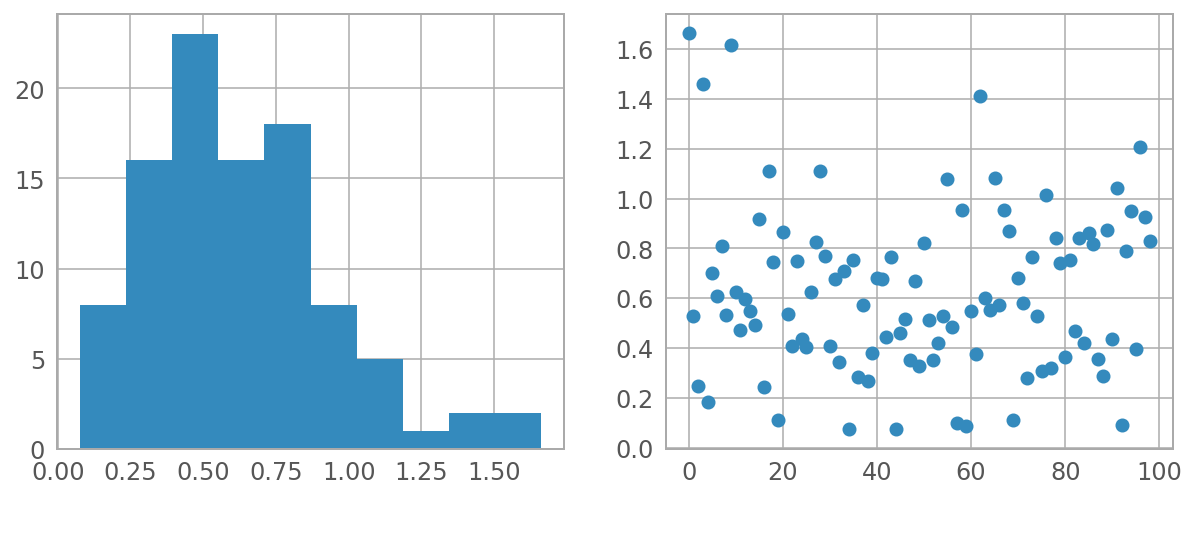

In [8]:
ds = (repdata[best_order][:-1] - repdata[best_order][1:]).norm()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(ds)
axs[1].scatter(np.arange(len(best_order)-1), ds)

<br><br>

- - - 


## 1D in the X

In [9]:
ii = np.arange(len(best_order))
meas = repdata[best_order].x

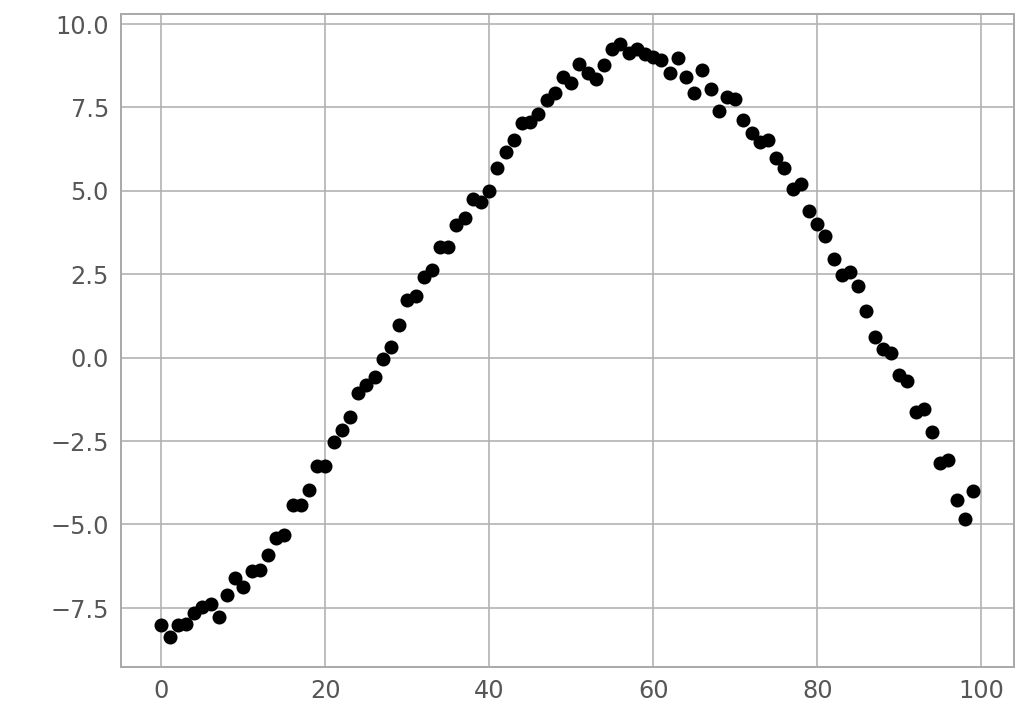

In [10]:
plt.scatter(ii, meas, c="k")

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/01-g-h-filter.ipynb

In [11]:
from filterpy.gh import GHFilter
ghf = GHFilter(x=-7.5, dx=-.5, dt=.5, g=0.4, h=0.8)

res, pred = ghf.batch_filter(meas, save_predictions=True)

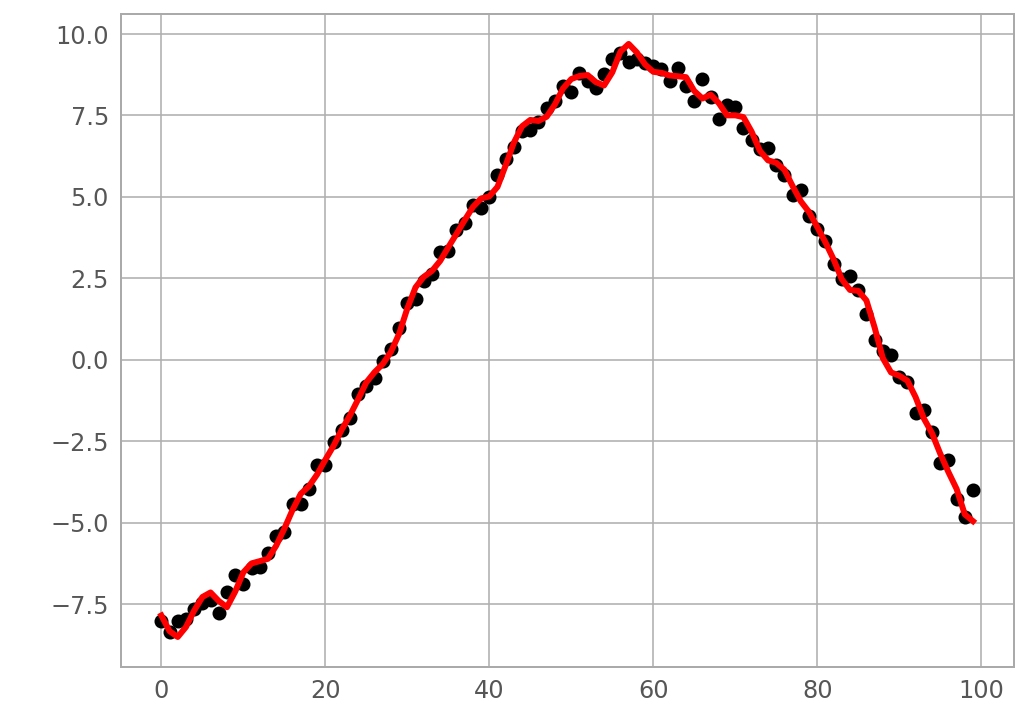

In [12]:
plt.scatter(ii, meas, c="k")
plt.plot(ii, res[1:,0], c="red", lw=3)

<br>

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/04-One-Dimensional-Kalman-Filters.ipynb

In [13]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

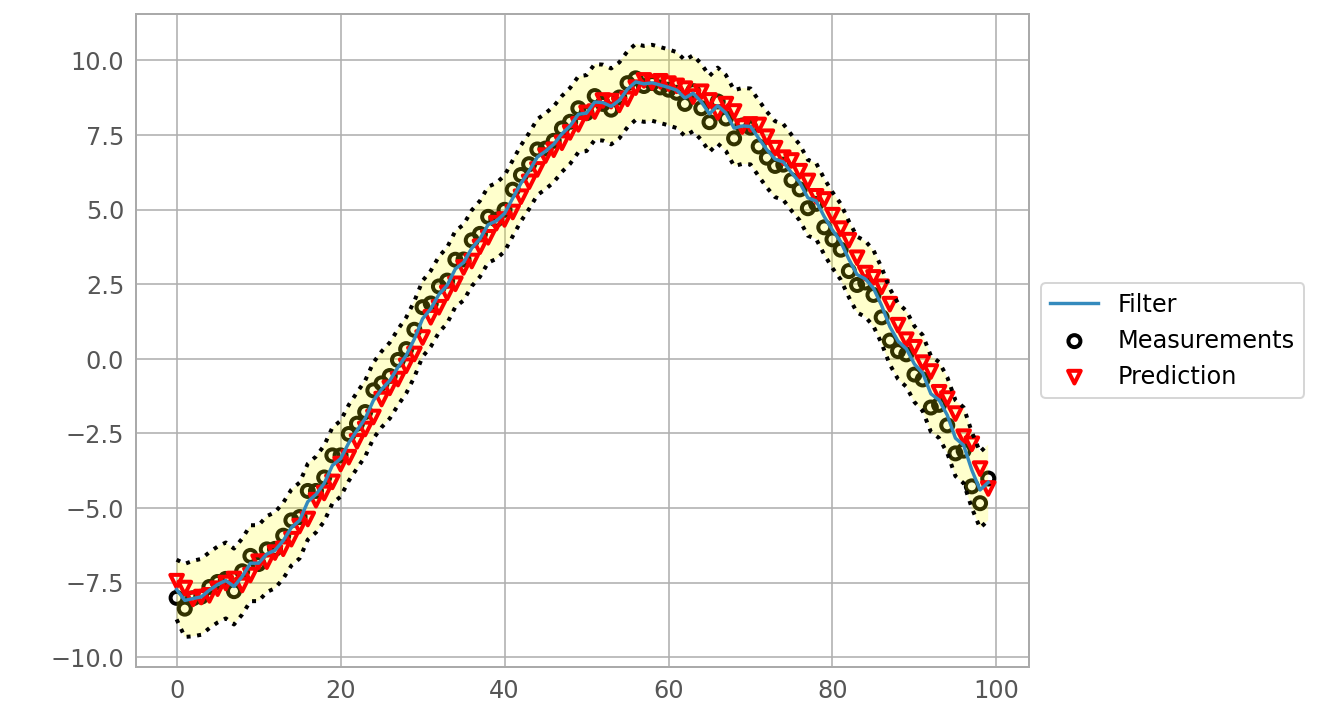

In [14]:
process_var = 1.  # variance in the dog's movement
sensor_var = 1.  # variance in the sensor

x = gaussian(-7.5, 0)
velocity = 0.1
dt = 0.5 # time step in seconds
process_model = gaussian(velocity*dt, process_var)

N = len(meas)


# print('PREDICT\t\t\tUPDATE')
# print('     x      var\t\t  z\t    x      var')

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))

# perform Kalman filter on measurement z
for i, z in enumerate(meas):
    prior = predict(x, process_model) 
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    priors[i] = prior
    xs[i] = x

# print('final estimate:        {:10.3f}'.format(x.mean))
# print('actual final position: {:10.3f}'.format(meas[-1]))

from streamtrack.kf_book import book_plots
book_plots.plot_measurements(meas)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
plt.show();

<br>

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

In [15]:
from filterpy.kalman import KalmanFilter
from filterpy.kalman import predict
from filterpy.common import Q_discrete_white_noise

Doing this as a hidden velocity variable

In [16]:
def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty

    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy

    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q

    return kf

In [17]:
from kf_book.mkf_internal import plot_track
from filterpy.common import Saver

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if track is None or zs is None:
        raise ValueError

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  
    s = Saver(kf)

    # run the kalman filter and store the results
    kf.batch_filter(zs, saver=s)
    s.to_array()
    Ms, Ps, _, _  = kf.rts_smoother(s.x, s.P, )

    s.to_array()
    if do_plot:
        plot_track(Ms[:, 0], track, zs, Ps, **kwargs)
        plt.tight_layout()

    return s

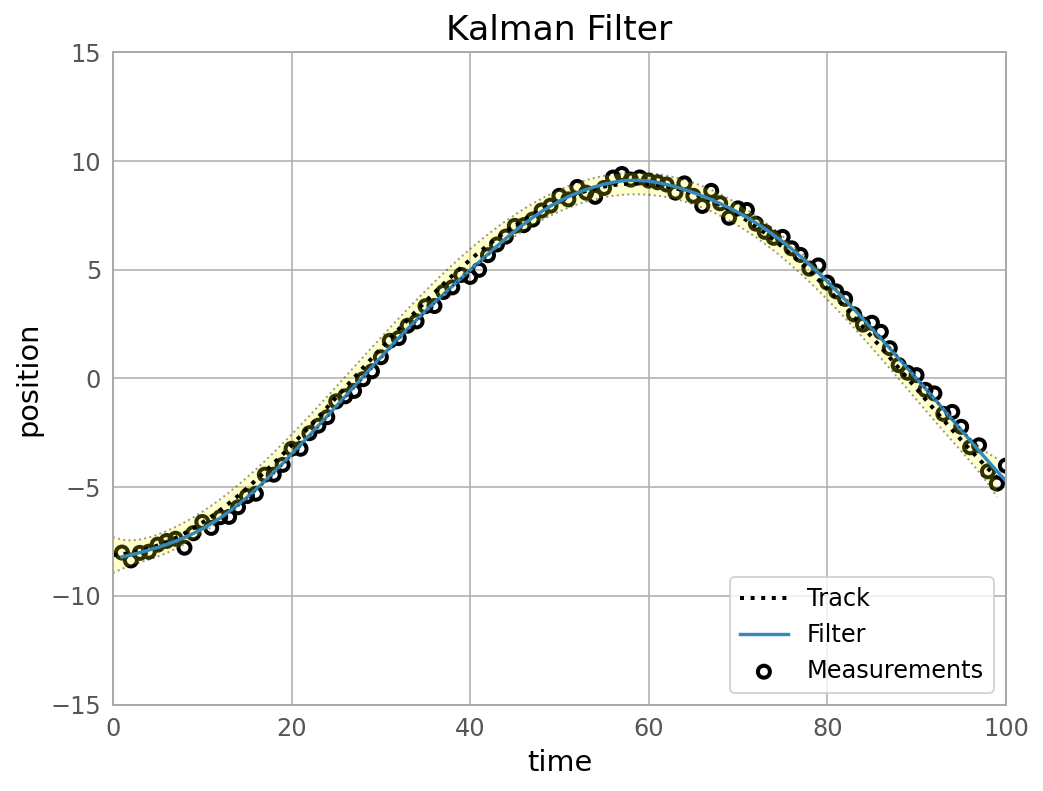

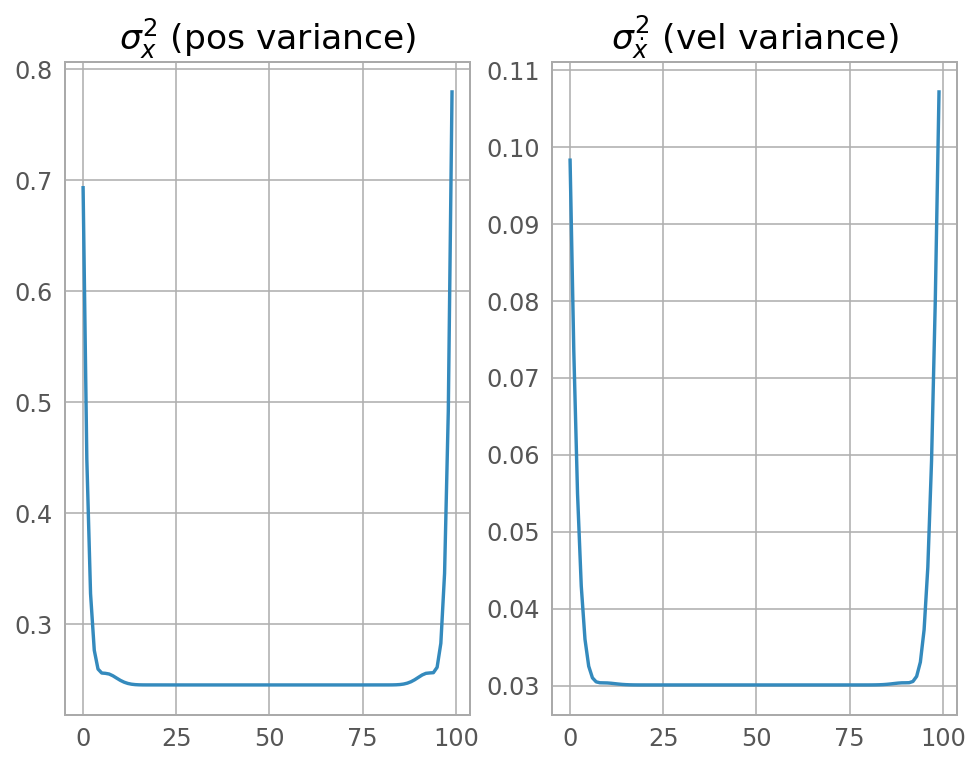

<Figure size 576x432 with 0 Axes>

In [18]:
P = np.diag([10., 10.])
saved = run(
    x0=[-7.5, 0], R=2, Q=0.03, P=P,
    track=osc.x.value, zs=meas,
    y_lim=[-15,15])

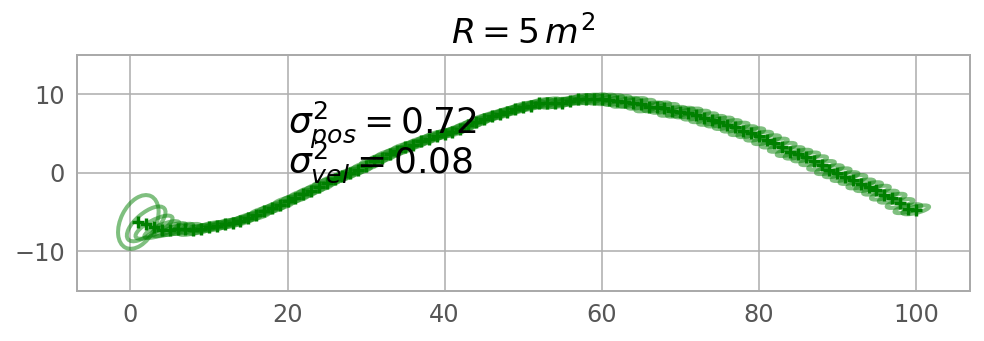

In [19]:
from kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=0, P=20., title=''):    
    track=osc.x.value
    zs=meas

    f = pos_vel_filter(x=(-7.5, 10.), R=R, Q=Q, P=P)
    s = Saver(f)

    f.batch_filter(zs, saver=s)
    s.to_array()
    f.rts_smoother(s.x, s.P)

    plot_track_ellipses(count, zs, s.x[:,0], s.P, title)
    plt.ylim(-15, 15)

# plt.figure(figsize=(10,6))
# plt.subplot(121)
plot_covariances(count=len(meas), R=2, Q=.02, P=5, title='$R = 5\, m^2$')
# plt.subplot(122)
# plot_covariances(R=.1, Q=.02, count=20, title='$R = 0.5\, m^2$')
# plt.show();

<br><br>

- - - 


## 3D Cartesian, fixed step

In [162]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag

kf = KalmanFilter(dim_x=6, dim_z=3)
dt = 0.5   # time step 1 second

# state transition function
kf.F = np.array([[1, dt, 0,  0, 0, 0],
                 [0,  1, 0,  0, 0, 0],
                 [0,  0, 1, dt, 0, 0],
                 [0,  0, 0,  1, 0, 0],
                 [0,  0, 0,  0, 1, dt],
                 [0,  0, 0,  0, 0, 1]])

# process noise matrix
kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.01, block_size=3)

# measurement function
h = np.array([[1, 0], [0, 0]])
kf.H = block_diag(h, h, h)[::2]
# kf.H

# measurement noise matrix
kf.R = np.diag([0.05, 0.05, 0.003])

# initial conditions
x = repdata[best_order[0]].xyz.value
kf.x = np.array([x[0], 0, x[1], 0, x[2], 0])
# kf.x

kf.P = np.eye(6) * 100.


In [163]:
zs = repdata[best_order].xyz.T.value
s = Saver(kf)

Ms, Ps, _, _ = kf.batch_filter(zs, saver=s)
s.to_array()
Ms, Ps, Ks, Pps  = kf.rts_smoother(s.x, s.P, )

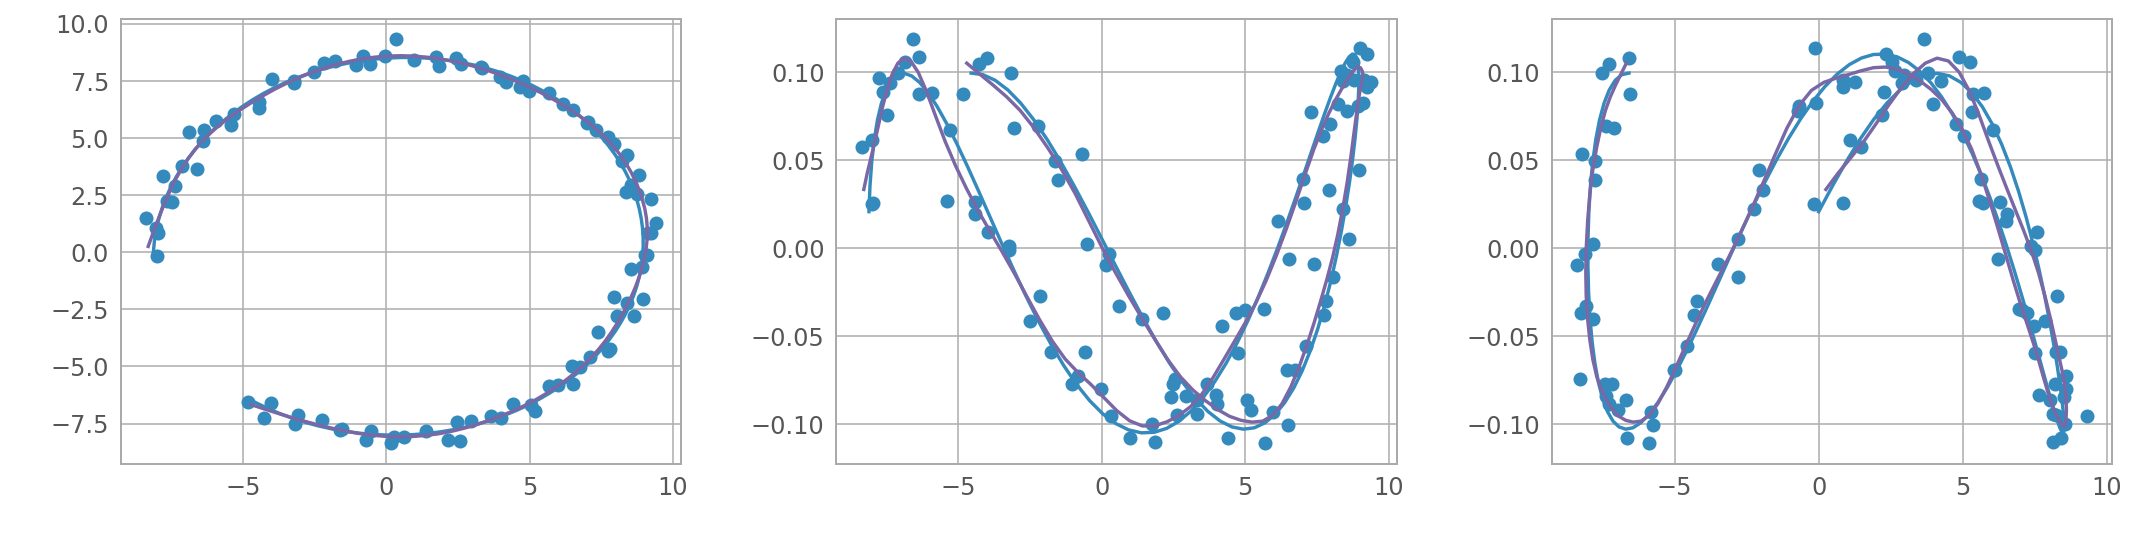

In [164]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(osc.x.value, osc.y.value)
axs[0].scatter(repdata.x, repdata.y)
axs[0].plot(Ms[:, 0], Ms[:, 2])

axs[1].plot(osc.x.value, osc.z.value)
axs[1].scatter(repdata.x, repdata.z)
axs[1].plot(Ms[:, 0], Ms[:, 4])

axs[2].plot(osc.y.value, osc.z.value)
axs[2].scatter(repdata.y, repdata.z)
axs[2].plot(Ms[:, 2], Ms[:, 4])

plt.tight_layout()
plt.show();

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

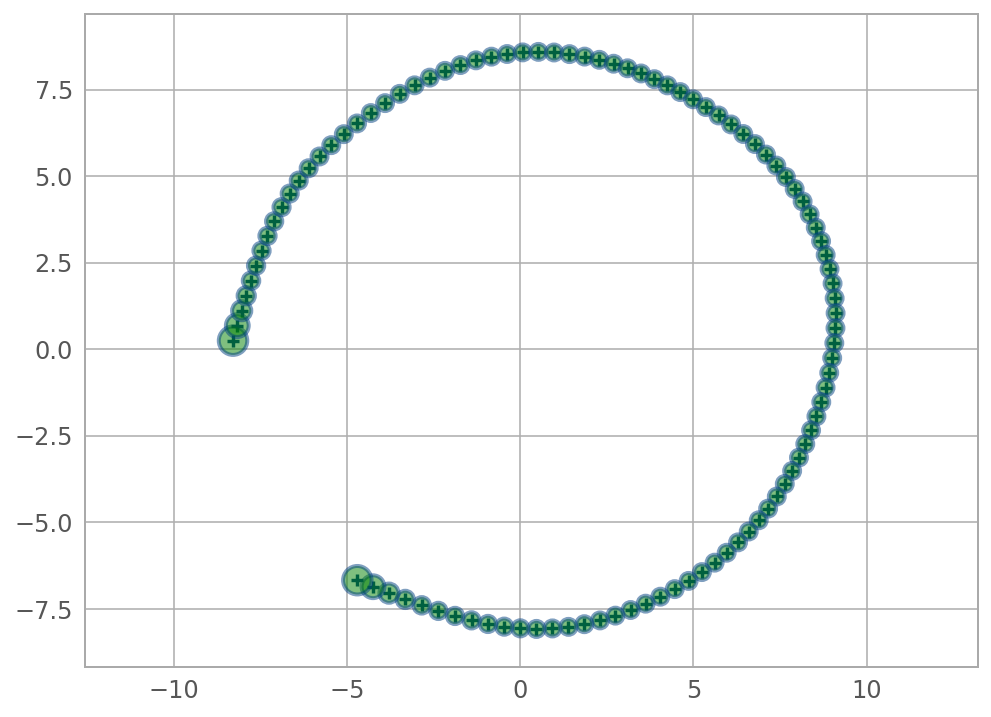

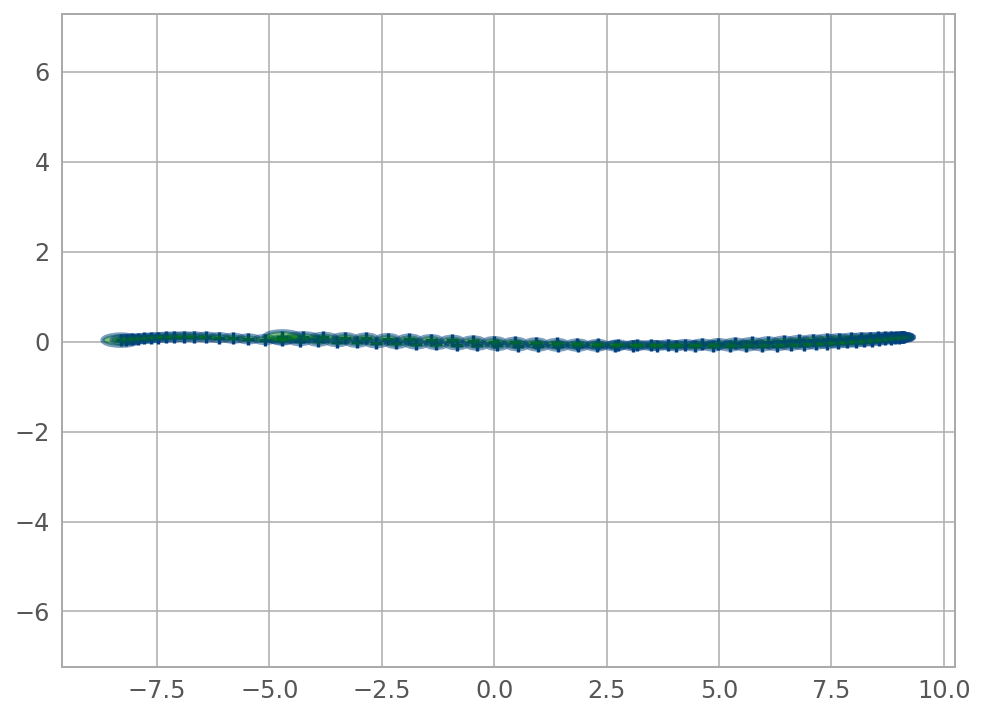

In [178]:
from filterpy.stats import plot_covariance

plt.figure()
for x, P in zip(Ms, Ps):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0], x[2])
    plot_covariance(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
plt.figure()
for x, P in zip(Ms, Ps):
    # covariance of x and z
    cov = np.array([[P[0, 0], P[4, 0]], 
                    [P[0, 4], P[4, 4]]])
    mean = (x[0], x[4])
    plot_covariance(mean, cov=cov, fc='g', std=3, alpha=0.5)

<br><br>

- - - 


## Hinfinity Filter

<br><br>

- - - 

<span style='font-size:40px;rvst-weight:650'>
    END
</span>